In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "png"

from data import *
from plotting import *
from regression import *
from utils import *




In [3]:
# Load data
pcd_df = load_pcd_df()

access_df = pcd_df.dropna(subset=['Model accessibility'])
len(access_df)

971

# Model Accessibility Charts

In [4]:
# Add year column
access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year

# Get counts of all models by year and model accessibility
# Only include 2015 and later because older models are rare
access_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

# Add up cumulative counts by accessibility status for each year 
access_counts['Cumulative for status'] = access_counts.groupby('Model accessibility')['Count'].cumsum()

# Sort from most closed to most open
sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
access_counts['Category_sorted'] = pd.Categorical(access_counts['Model accessibility'], categories=sort_order, ordered=True)
access_counts = access_counts.sort_values(['Category_sorted', 'Year'])

access_counts.head(20)

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_46214/399375725.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Model accessibility,Count,Cumulative for status,Category_sorted
1,2015,Unreleased,6,6,Unreleased
5,2016,Unreleased,19,25,Unreleased
7,2017,Unreleased,30,55,Unreleased
10,2018,Unreleased,45,100,Unreleased
14,2019,Unreleased,93,193,Unreleased
18,2020,Unreleased,55,248,Unreleased
23,2021,Unreleased,74,322,Unreleased
29,2022,Unreleased,47,369,Unreleased
35,2023,Unreleased,37,406,Unreleased
41,2024,Unreleased,14,420,Unreleased


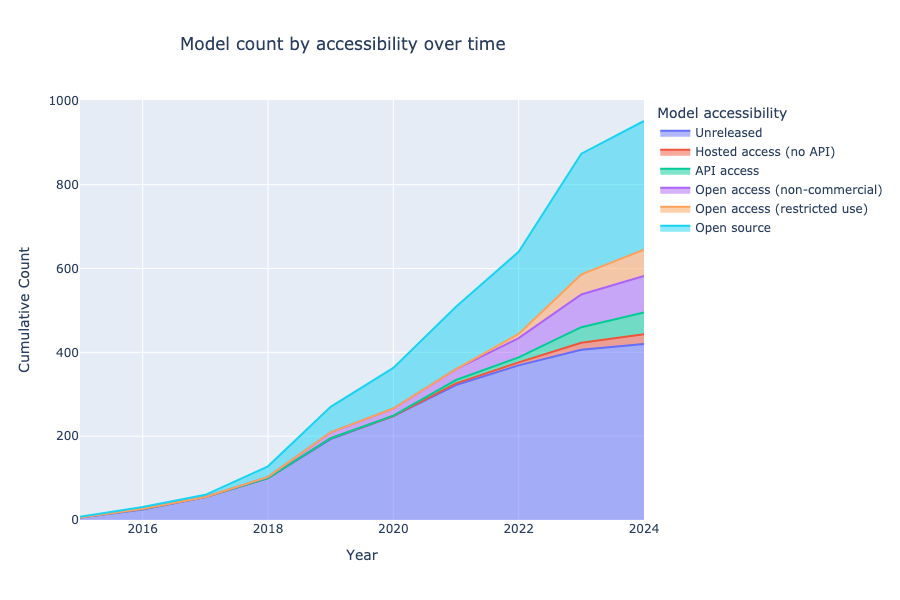

In [5]:
# Cumulative area chart
fig = px.area(access_counts, x='Year', y='Cumulative for status', color='Model accessibility', line_group='Model accessibility',
              labels={'Cumulative for status': 'Cumulative Count', 'Year': 'Year'},
              title='Model count by accessibility over time')

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

Commentary: around half of models are unreleased as of 2024, but the proportion has been shrinking over time. Before 2018 or so, releasing model weights was rare (academic projects often shared training code, but not weights)

In [6]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status and cumulative total across all statuses
def normalize_counts(access_counts):
    
    # Get df with total models per year, and cumulative totals
    total_counts = access_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
    total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    access_counts_wide = access_counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(access_counts_wide.index.min(), access_counts_wide.index.max() + 1))

    # Fill in the NaN values
    access_counts_wide_filled = access_counts_wide.reindex(all_years).ffill().fillna(0)
    access_counts_wide_filled = access_counts_wide_filled.reset_index(names=["Year"])
    
    # Unpivot
    access_counts_filled = (access_counts_wide_filled.melt(id_vars='Year', 
                                     var_name='Model accessibility', 
                                     value_name='Cumulative for status')
                               .reset_index(drop=True))
    
    # Join with total counts df to get the cumulative totals
    normalized_counts = pd.merge(access_counts_filled, total_counts, on='Year')
    
    # Divide annual counts by cumulative counts to find cumulative proportions by year
    normalized_counts['proportion'] = normalized_counts['Cumulative for status'] / normalized_counts['Cumulative Total']
    
    # Sort using custom order
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
    normalized_counts['Category_sorted'] = pd.Categorical(normalized_counts['Model accessibility'], categories=sort_order, ordered=True)
    normalized_counts = normalized_counts.sort_values(['Category_sorted', 'Year'])
    
    return normalized_counts

In [7]:
normalized_counts = normalize_counts(access_counts)

normalized_counts.head(20)

,Year,Model accessibility,Cumulative for status,Yearly Total,Cumulative Total,proportion,Category_sorted
50,2015,Unreleased,6.0,8,8,0.750000,Unreleased
51,2016,Unreleased,25.0,23,31,0.806452,Unreleased
52,2017,Unreleased,55.0,31,62,0.887097,Unreleased
53,2018,Unreleased,100.0,67,129,0.775194,Unreleased
54,2019,Unreleased,193.0,141,270,0.714815,Unreleased
55,2020,Unreleased,248.0,95,365,0.679452,Unreleased
56,2021,Unreleased,322.0,144,509,0.632613,Unreleased
57,2022,Unreleased,369.0,131,640,0.576562,Unreleased
58,2023,Unreleased,406.0,234,874,0.464531,Unreleased
59,2024,Unreleased,420.0,78,952,0.441176,Unreleased


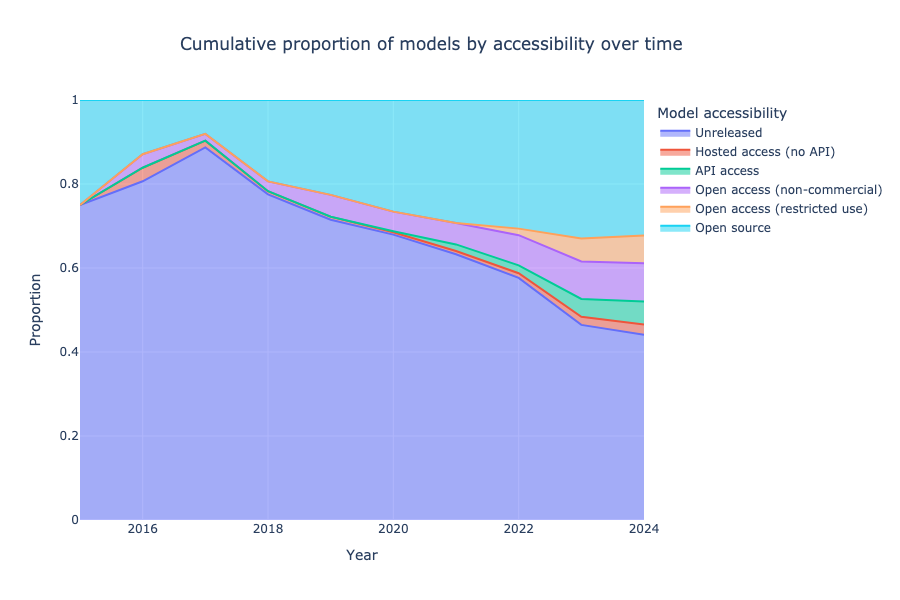

In [8]:
fig = px.area(normalized_counts, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative proportion of models by accessibility over time')

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'proportion_by_accessibility')
fig.show()

This chart shows the proportions over time more clearly - open weights have never been very rare (at least 10%). But open models have become much more common over time, making up around half of models today. The large majority of those are permissively licensed ("Open source") even today but open with restrictions has become more common over time.

# Code vs Model Accessibility

In [9]:
print(f"There are {len(access_df[access_df['Code accessibility'].isna()])} models with marked code access and unmarked code access")

There are 137 models with marked code access and unmarked code access


In [10]:
# filter for code accessibility
access_df = access_df.dropna(subset=['Code accessibility'])

In [11]:
model_open_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
code_open_categories = ['Open source', 'Open access (non-commercial)', 'Open access (restricted use)']


# Add open/closed binary columns
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in model_open_categories else 'Closed'
)

access_df['Code open/closed'] = access_df['Code accessibility'].apply(
    lambda x: 'Open' if x in code_open_categories else 'Closed'
)

In [12]:
access_df.head(8)

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training compute cost (2023 USD),Training dataset size,Sparsity,Year,Model open/closed,Code open/closed
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",2023-12-06,NaN,Hosted access (no API),NaN,Unreleased,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,NaN,132000000.0,Industry,NaN,$29827341.92,Gemini 1.0 Ultra,NaN,2023,Closed,Closed
1,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,2023-03-15,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2303.08774,OpenAI,...,NaN,57000000.0,Industry,NaN,$40586592.58,GPT-4,GPT-4,2023,Closed,Closed
2,Mistral Large,Language,Chat,2024-02-26,NaN,API access,NaN,Unreleased,https://mistral.ai/news/mistral-large/,Mistral AI,...,NaN,NaN,Industry,NaN,NaN,Mistral Large,NaN,2024,Closed,Closed
4,MegaScale (Production),Language,Language modelling/generation,2024-02-23,Code for MegaScale (also called veScale) train...,Unreleased,NaN,Unreleased,https://arxiv.org/abs/2402.15627,"ByteDance,Peking University",...,NaN,NaN,"Industry,Academia",NaN,NaN,MegaScale (Production),NaN,2024,Closed,Closed
5,Inflection-2,Language,"Language modelling,Language modelling/generati...",2023-11-22,"via Pi, no API",Hosted access (no API),NaN,Unreleased,https://inflection.ai/inflection-2,Inflection AI,...,NaN,NaN,Industry,NaN,$12961959.00,Inflection-2,NaN,2023,Closed,Closed
6,Inflection-2.5,Language,Chat,2024-03-07,NaN,Hosted access (no API),NaN,Unreleased,https://inflection.ai/inflection-2-5,Inflection AI,...,NaN,NaN,Industry,NaN,NaN,Inflection-2.5,NaN,2024,Closed,Closed
7,PaLM 2,Language,"Language modelling,Language modelling/generation",2023-05-10,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2305.10403,Google,...,NaN,NaN,Industry,NaN,$4865570.06,PaLM 2,NaN,2023,Closed,Closed
8,Llama 3-70B,Language,"Chat,Language modelling/generation,Code genera...",2024-04-18,https://github.com/meta-llama/llama3/blob/main...,Open access (restricted use),NaN,Open access (restricted use),https://ai.meta.com/blog/meta-llama-3/,Meta AI,...,NaN,6400000.0,Industry,checked,NaN,Llama 3-70B,NaN,2024,Open,Open


In [13]:
model_counts = access_df.groupby('Model accessibility').size().reset_index(name='Counts')
model_counts

,Model accessibility,Counts
0,API access,31
1,Hosted access (no API),17
2,Open access (non-commercial),75
3,Open access (restricted use),45
4,Open source,258
5,Unreleased,408


In [14]:
code_counts = access_df.groupby('Code accessibility').size().reset_index(name='Counts')
code_counts

,Code accessibility,Counts
0,Open access (non-commercial),75
1,Open access (restricted use),7
2,Open source,332
3,Unreleased,420


In [15]:
counts = access_df.groupby(['Model accessibility', 'Code accessibility']).size().reset_index(name='Counts')
pivoted = counts.pivot(index='Model accessibility', columns='Code accessibility', values='Counts').fillna(0).style.format("{:.0f}")

# code access against model access
pivoted

Code accessibility,Open access (non-commercial),Open access (restricted use),Open source,Unreleased
Model accessibility,,,,
API access,0,0,0,31
Hosted access (no API),1,0,1,15
Open access (non-commercial),36,1,16,22
Open access (restricted use),0,4,13,28
Open source,2,1,196,59
Unreleased,36,1,106,265


In [16]:
open_counts = access_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
open_counts = open_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

# code open vs model open
open_counts

Code open/closed,Closed,Open
Model open/closed,,
Closed,311,145
Open,109,269


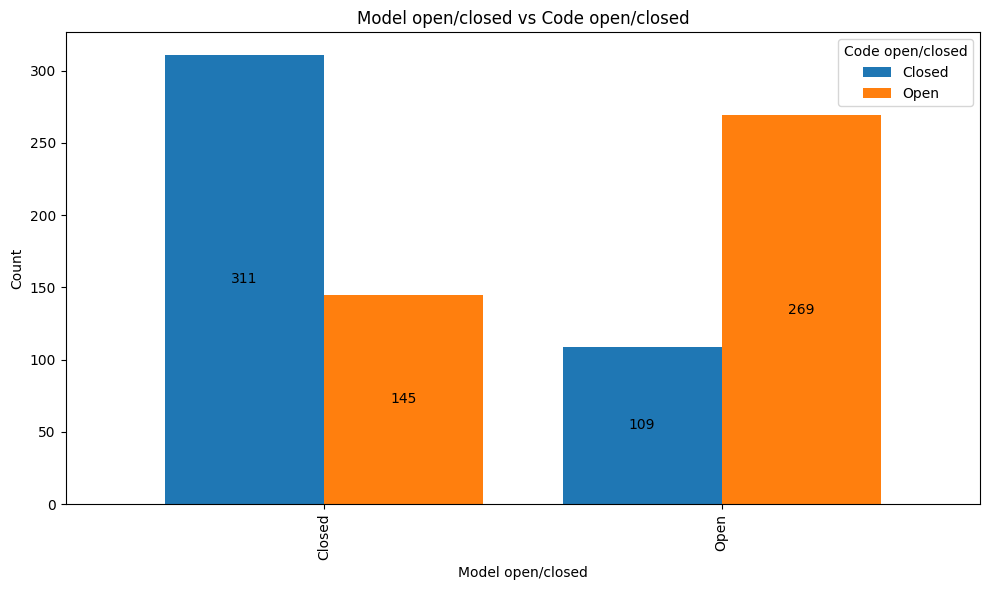

In [17]:
ax = open_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customize the chart
plt.title('Model open/closed vs Code open/closed')
plt.ylabel('Count')


# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

Model openness and code openness are reasonably correlated - most closed-weight models have closed code, while somewhat more open models have open code than closed code. This also applies across the other direction - most closed code models have closed weights, most open code models have open weights.

In [18]:
open_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

open_counts.head(10)

,Year,Model open/closed,Code open/closed,Count,Cumulative
0,2015,Closed,Closed,5,5
1,2015,Closed,Open,1,1
2,2015,Open,Open,2,2
3,2016,Closed,Closed,17,22
4,2016,Closed,Open,2,3
5,2016,Open,Open,2,4
6,2017,Closed,Closed,15,37
7,2017,Closed,Open,13,16
8,2017,Open,Open,1,5
9,2018,Closed,Closed,32,69


In [19]:
total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
total_counts

,Year,Yearly Total,Cumulative Total
0,2015,8,8
1,2016,21,29
2,2017,29,58
3,2018,64,122
4,2019,137,259
5,2020,91,350
6,2021,138,488
7,2022,110,598
8,2023,171,769
9,2024,47,816


In [20]:
open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()
open_counts_wide

Model open/closed  Year Closed        Open       
Code open/closed        Closed  Open  Open Closed
0                  2015    5.0   1.0   2.0    0.0
1                  2016   17.0   2.0   2.0    0.0
2                  2017   15.0  13.0   1.0    0.0
3                  2018   32.0  11.0  20.0    1.0
4                  2019   56.0  35.0  37.0    9.0
5                  2020   40.0  15.0  30.0    6.0
6                  2021   49.0  30.0  51.0    8.0
7                  2022   24.0  21.0  48.0   17.0
8                  2023   39.0  10.0  67.0   55.0
9                  2024   20.0   3.0  11.0   13.0

In [21]:
print(open_counts_wide.columns.to_list())
print(open_counts_wide.index.names)

[('Year', ''), ('Closed', 'Closed'), ('Closed', 'Open'), ('Open', 'Open'), ('Open', 'Closed')]
[None]


In [22]:
# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

open_counts_wide

,Year,Model Closed Code Closed,Model Closed Code Open,Model Open Code Open,Model Open Code Closed
0,2015,5.0,1.0,2.0,0.0
1,2016,17.0,2.0,2.0,0.0
2,2017,15.0,13.0,1.0,0.0
3,2018,32.0,11.0,20.0,1.0
4,2019,56.0,35.0,37.0,9.0
5,2020,40.0,15.0,30.0,6.0
6,2021,49.0,30.0,51.0,8.0
7,2022,24.0,21.0,48.0,17.0
8,2023,39.0,10.0,67.0,55.0
9,2024,20.0,3.0,11.0,13.0


In [23]:
# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled.head(20)

,Year,Category,Count
0,2015,Model Closed Code Closed,5.0
1,2016,Model Closed Code Closed,17.0
2,2017,Model Closed Code Closed,15.0
3,2018,Model Closed Code Closed,32.0
4,2019,Model Closed Code Closed,56.0
5,2020,Model Closed Code Closed,40.0
6,2021,Model Closed Code Closed,49.0
7,2022,Model Closed Code Closed,24.0
8,2023,Model Closed Code Closed,39.0
9,2024,Model Closed Code Closed,20.0


In [24]:
open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']
with_totals.head(20)

,Year,Category,Count,Cumulative for Category,Yearly Total,Cumulative Total,proportion
0,2015,Model Closed Code Closed,5.0,5.0,8,8,0.625000
1,2016,Model Closed Code Closed,17.0,22.0,21,29,0.758621
2,2017,Model Closed Code Closed,15.0,37.0,29,58,0.637931
3,2018,Model Closed Code Closed,32.0,69.0,64,122,0.565574
4,2019,Model Closed Code Closed,56.0,125.0,137,259,0.482625
5,2020,Model Closed Code Closed,40.0,165.0,91,350,0.471429
6,2021,Model Closed Code Closed,49.0,214.0,138,488,0.438525
7,2022,Model Closed Code Closed,24.0,238.0,110,598,0.397993
8,2023,Model Closed Code Closed,39.0,277.0,171,769,0.360208
9,2024,Model Closed Code Closed,20.0,297.0,47,816,0.363971


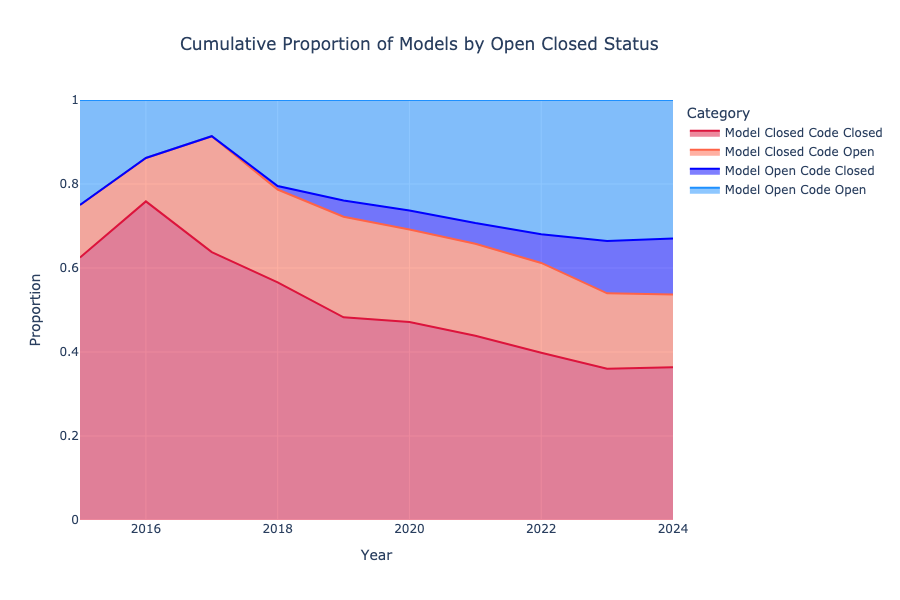

In [25]:
# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['crimson', 'tomato', 'blue', 'dodgerblue']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative Proportion of Models by Open Closed Status', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)
fig

This chart shows the proportions across the four categories of model open/closed and code open/closed. The red areas are open-weight models and the blue areas are closed-weight, while the lighter colors are code open and the darker colors are code closed. Among open-weight models, code closed has become more common. Intuitively, this is consistent with the rise of the commercial open-source industry, which releases model weights but does not wish to give competitors the ability to recreate their base models.